In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor  
from sklearn.linear_model import LinearRegression  
from xgboost import XGBRegressor as XGBR 
from sklearn.model_selection import cross_val_score,train_test_split,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,log_loss
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_error  
from sklearn.metrics import accuracy_score
import shap  
shap.initjs() 

data = pd.read_excel(r'd:\Desktop\1222\1225复合毒性数据.xlsx')

newdata = pd.get_dummies(data)
pd.DataFrame(newdata)

x = newdata.drop('Survival(%)',axis=1)
y = newdata['Survival(%)']

x.columns = x.columns.astype(str)
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x)

In [ ]:
# 使用最佳参数初始化基础学习器  
best_rf = RandomForestRegressor(n_estimators=85, max_depth=19, random_state=55)  
best_gb = GradientBoostingRegressor(n_estimators=199, random_state=138, max_depth=7)  
best_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=60, gamma=0)  

# 定义基础学习器和堆叠回归器  
estimators = [  
    ('rf', best_rf),  
    ('gbdt', best_gb),  
    ('xgb', best_xgb)  
]  

stacking_reg = StackingRegressor(  
    estimators=estimators,  
    final_estimator=LinearRegression(),  
    cv=5  
)  

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)  

# 训练堆叠回归器  
stacking_reg.fit(X_train, y_train)  

# 计算训练集和测试集的 R² RMSE 及 MAE 
cv_r2 = cross_val_score(stacking_reg, X_train, y_train, cv=5, scoring='r2')  
cv_rmse = -cross_val_score(stacking_reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')  
cv_mae = -cross_val_score(stacking_reg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')  
 
y_pred = stacking_reg.predict(X_test)  

test_r2 = r2_score(y_test, y_pred)  
test_rmse = mean_squared_error(y_test, y_pred, squared=False)  
test_mae = mean_absolute_error(y_test, y_pred)  

X_train.columns = newdata.columns

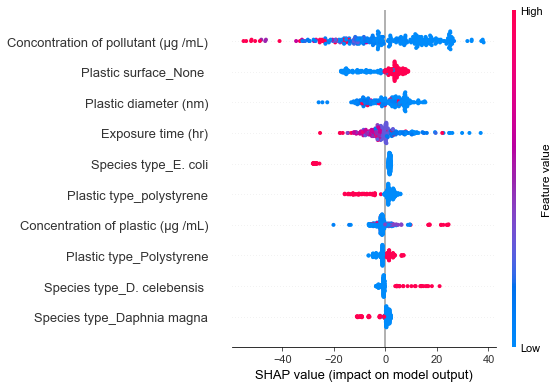

In [ ]:
# SHAP计算  
explainer = shap.TreeExplainer(stacking_reg)  
shap_values = explainer.shap_values(X_train)  

mean_shap_values = np.abs(shap_values).mean(axis=0)  

top_indices = np.argsort(mean_shap_values)[-10:]  
shap_values_top = shap_values[:, top_indices]   
Xtrain_top = X_train.iloc[:, top_indices]  

Xtrain_top.columns = [
    col.replace("(", " (").replace("/", " /") for col in Xtrain_top.columns
]

# 设置字体  
plt.rcParams['font.family'] = 'Arial'  

# 绘制SHAP值的蜂巢图  
plt.figure(figsize=(10, 8))  
shap.summary_plot(
    shap_values_top, 
    features=Xtrain_top, 
    feature_names=Xtrain_top.columns, 
    show=False  
)  

# 保存 
plt.savefig(r"d:\Desktop\1222\0108top_10shap.png", format="png", dpi=300, bbox_inches="tight")  
plt.show()  
